In [1]:
import numpy as np
import math

class TrafficGenerator:
    def __init__(self, max_steps, n_cars_generated):
        self._n_cars_generated = n_cars_generated  # how many cars per episode
        self._max_steps = max_steps

    def generate_routefile(self, seed):
        """
        Generation of the route of every car for one episode
        """
        np.random.seed(seed)  # make tests reproducible

        # the generation of cars is distributed according to a weibull distribution
        timings = np.random.weibull(2, self._n_cars_generated)
        timings = np.sort(timings)

        # reshape the distribution to fit the interval 0:max_steps
        car_gen_steps = []
        min_old = math.floor(timings[1])
        max_old = math.ceil(timings[-1])
        min_new = 0
        max_new = self._max_steps
        for value in timings:
            car_gen_steps = np.append(car_gen_steps, ((max_new - min_new) / (max_old - min_old)) * (value - max_old) + max_new)

        car_gen_steps = np.rint(car_gen_steps)  # round every value to int -> effective steps when a car will be generated

        # produce the file for cars generation, one car per line
        with open("intersection/episode_routes.rou.xml", "w") as routes:
            print("""<routes>
            <vType accel="1.0" decel="4.5" id="standard_car" length="5.0" minGap="2.5" maxSpeed="25" sigma="0.5" />

            <route id="W_N" edges="W2TL TL2N"/>
            <route id="W_E" edges="W2TL TL2E"/>
            <route id="W_S" edges="W2TL TL2S"/>
            <route id="N_W" edges="N2TL TL2W"/>
            <route id="N_E" edges="N2TL TL2E"/>
            <route id="N_S" edges="N2TL TL2S"/>
            <route id="E_W" edges="E2TL TL2W"/>
            <route id="E_N" edges="E2TL TL2N"/>
            <route id="E_S" edges="E2TL TL2S"/>
            <route id="S_W" edges="S2TL TL2W"/>
            <route id="S_N" edges="S2TL TL2N"/>
            <route id="S_E" edges="S2TL TL2E"/>""", file=routes)

            for car_counter, step in enumerate(car_gen_steps):
                straight_or_turn = np.random.uniform()
                if straight_or_turn < 0.75:  # choose direction: straight or turn - 75% of times the car goes straight
                    route_straight = np.random.randint(1, 5)  # choose a random source & destination
                    if route_straight == 1:
                        print('    <vehicle id="W_E_%i" type="standard_car" route="W_E" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_straight == 2:
                        print('    <vehicle id="E_W_%i" type="standard_car" route="E_W" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_straight == 3:
                        print('    <vehicle id="N_S_%i" type="standard_car" route="N_S" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    else:
                        print('    <vehicle id="S_N_%i" type="standard_car" route="S_N" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                else:  # car that turn -25% of the time the car turns
                    route_turn = np.random.randint(1, 9)  # choose random source source & destination
                    if route_turn == 1:
                        print('    <vehicle id="W_N_%i" type="standard_car" route="W_N" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 2:
                        print('    <vehicle id="W_S_%i" type="standard_car" route="W_S" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 3:
                        print('    <vehicle id="N_W_%i" type="standard_car" route="N_W" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 4:
                        print('    <vehicle id="N_E_%i" type="standard_car" route="N_E" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 5:
                        print('    <vehicle id="E_N_%i" type="standard_car" route="E_N" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 6:
                        print('    <vehicle id="E_S_%i" type="standard_car" route="E_S" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 7:
                        print('    <vehicle id="S_W_%i" type="standard_car" route="S_W" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)
                    elif route_turn == 8:
                        print('    <vehicle id="S_E_%i" type="standard_car" route="S_E" depart="%s" departLane="random" departSpeed="10" />' % (car_counter, step), file=routes)

            print("</routes>", file=routes)

In [3]:
import traci
import numpy as np
import random
import time
from collections import defaultdict

# Q-Learning parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration rate
EPISODES = 100  # Number of training episodes

# Traffic light phases (from the net file)
PHASES = [
    "GGGGrrrrrrGGGGrrrrrr",  # Phase 0 - North/South straight
    "yyyyrrrrrryyyyrrrrrr",  # Phase 1 - North/South yellow
    "rrrrGrrrrrrrrrGrrrrr",  # Phase 2 - East/West straight
    "rrrryrrrrrrrrryrrrrr",  # Phase 3 - East/West yellow
    "rrrrrGGGGrrrrrrGGGGr",  # Phase 4 - North/South left
    "rrrrryyyyrrrrrryyyyr",  # Phase 5 - North/South left yellow
    "rrrrrrrrrGrrrrrrrrrG",  # Phase 6 - East/West left
    "rrrrrrrrryrrrrrrrrry"   # Phase 7 - East/West left yellow
]

# State discretization parameters
MAX_QUEUE = 20  # Maximum vehicles considered in queue
QUEUE_BINS = 4  # Number of bins for queue length discretization

class QLearningAgent:
    def __init__(self):
        self.q_table = defaultdict(lambda: np.zeros(len(PHASES)))
        self.current_state = None
        self.current_action = None
        
    def get_state(self):
        """Discretize the current traffic state"""
        state = []
        
        # Get queue lengths for each approach
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            queue_length = len(traci.edge.getLastStepVehicleIDs(approach))
            # Discretize queue length
            discrete_length = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state.append(discrete_length)
            
        return tuple(state)
    
    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if random.random() < EPSILON:
            return random.randint(0, len(PHASES) - 1)
        else:
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """Update Q-table using Q-learning update rule"""
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + GAMMA * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += ALPHA * td_error
    
    def get_reward(self):
        """Calculate reward based on waiting time"""
        total_waiting = 0
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            for veh_id in traci.edge.getLastStepVehicleIDs(approach):
                total_waiting += traci.vehicle.getWaitingTime(veh_id)
                
        # Negative reward to minimize waiting time
        return -total_waiting

def run_simulation():
    # Initialize SUMO
    sumo_cmd = ["sumo", "-c", "sumo_config.sumocfg"]
    traci.start(sumo_cmd)
    
    agent = QLearningAgent()
    
    for episode in range(EPISODES):
        traci.load(["--start", "-c", "sumo_config.sumocfg"])
        step = 0
        total_reward = 0
        
        # Get initial state
        state = agent.get_state()
        
        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:  # Run for max 1 hour
            # Choose action
            action = agent.choose_action(state)
            
            # Set the traffic light phase
            traci.trafficlight.setPhase("TL", action)
            traci.trafficlight.setPhaseDuration("TL", 10)  # 10-second phase
            
            # Simulate for the phase duration
            for _ in range(10):
                traci.simulationStep()
                step += 1
            
            # Get new state and reward
            next_state = agent.get_state()
            reward = agent.get_reward()
            total_reward += reward
            
            # Learn from the experience
            agent.learn(state, action, reward, next_state)
            
            # Update state
            state = next_state
        
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    
    traci.close()

if __name__ == "__main__":
    run_simulation()

Episode 1, Total Reward: -394838.0
Episode 2, Total Reward: -197265.0
Episode 3, Total Reward: -196719.0
Episode 4, Total Reward: -172321.0
Episode 5, Total Reward: -286914.0
Episode 6, Total Reward: -259762.0
Episode 7, Total Reward: -183983.0
Episode 8, Total Reward: -270598.0
Episode 9, Total Reward: -156703.0
Episode 10, Total Reward: -177288.0
Episode 11, Total Reward: -183598.0
Episode 12, Total Reward: -255846.0
Episode 13, Total Reward: -216404.0
Episode 14, Total Reward: -203030.0
Episode 15, Total Reward: -149321.0
Episode 16, Total Reward: -161153.0
Episode 17, Total Reward: -143811.0
Episode 18, Total Reward: -239083.0
Episode 19, Total Reward: -139579.0
Episode 20, Total Reward: -250916.0
Episode 21, Total Reward: -229670.0
Episode 22, Total Reward: -203617.0
Episode 23, Total Reward: -126849.0
Episode 24, Total Reward: -175827.0
Episode 25, Total Reward: -227617.0
Episode 26, Total Reward: -202842.0
Episode 27, Total Reward: -235325.0
Episode 28, Total Reward: -233077.0
E

Episode 1, Total Reward: -3801.9, Epsilon: 0.995
Episode 2, Total Reward: -1573.6, Epsilon: 0.990
Episode 3, Total Reward: -1288.4, Epsilon: 0.985
Episode 4, Total Reward: -1289.2, Epsilon: 0.980
Episode 5, Total Reward: -1383.5, Epsilon: 0.975
Episode 6, Total Reward: -1965.5, Epsilon: 0.970
Episode 7, Total Reward: -1199.0, Epsilon: 0.966
Episode 8, Total Reward: -1249.3, Epsilon: 0.961
Episode 9, Total Reward: -1072.3, Epsilon: 0.956
Episode 10, Total Reward: -1420.1, Epsilon: 0.951
Episode 11, Total Reward: -1781.0, Epsilon: 0.946
Episode 12, Total Reward: -2111.0, Epsilon: 0.942
Episode 13, Total Reward: -1661.3, Epsilon: 0.937
Episode 14, Total Reward: -1370.6, Epsilon: 0.932
Episode 15, Total Reward: -3260.3, Epsilon: 0.928
Episode 16, Total Reward: -1778.4, Epsilon: 0.923
Episode 17, Total Reward: -1930.5, Epsilon: 0.918
Episode 18, Total Reward: -1800.0, Epsilon: 0.914
Episode 19, Total Reward: -1189.1, Epsilon: 0.909
Episode 20, Total Reward: -1259.3, Epsilon: 0.905
Episode 2

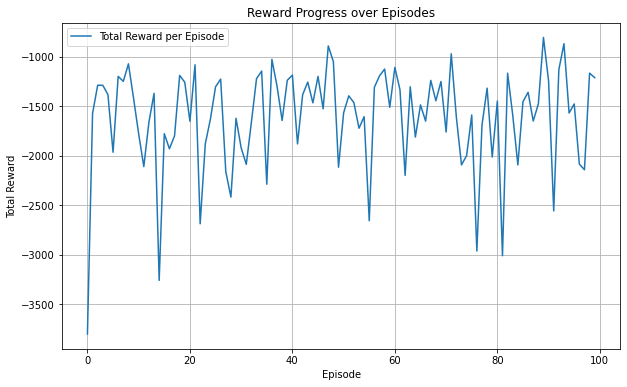

In [23]:
import traci
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    traci.close()
except Exception:
    pass

# Hyperparameters
ALPHA = 0.2
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
EPISODES = 100

# Simplified Phase Settings (Green phases only)
GREEN_PHASES = [0, 2, 4, 6]
YELLOW_DURATION = 3
MIN_GREEN_DURATION = 10
MAX_GREEN_DURATION = 30

# State parameters
MAX_QUEUE = 40
QUEUE_BINS = 8
SPEED_BINS = 4

class QLearningAgent:
    def __init__(self):
        self.q_table = defaultdict(lambda: np.zeros(len(GREEN_PHASES)))
        self.epsilon = EPSILON_START
        self.current_phase = 0
        self.phase_duration = 0
        self.yellow_time = 0

    def get_state(self):
        state_features = []
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            # Define lane_id at the beginning for each approach
            lane_id = f"{approach}_0"
            
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            queue_length = len(vehicles)
            queue_state = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state_features.append(queue_state)

            # Get max speed for the lane
            max_speed = traci.lane.getMaxSpeed(lane_id)
            
            if vehicles:
                speeds = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles]
                avg_speed = sum(speeds)/len(speeds)
            else:
                avg_speed = max_speed

            # Avoid division by zero
            if max_speed > 0:
                speed_state = int(avg_speed // (max_speed/SPEED_BINS))
            else:
                speed_state = 0
                
            state_features.append(min(speed_state, SPEED_BINS - 1))
        return tuple(state_features)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(GREEN_PHASES)
        else:
            return GREEN_PHASES[np.argmax(self.q_table[state])]

    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state][GREEN_PHASES.index(action)]
        max_future = np.max(self.q_table[next_state])
        new_value = (1 - ALPHA) * old_value + ALPHA * (reward + GAMMA * max_future)
        self.q_table[state][GREEN_PHASES.index(action)] = new_value

    def get_reward(self):
        total_waiting = 0
        total_stopped = 0
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            total_stopped += traci.edge.getLastStepHaltingNumber(approach)
            for veh_id in vehicles:
                total_waiting += traci.vehicle.getAccumulatedWaitingTime(veh_id)
        reward = - (total_waiting / 1000 + total_stopped * 0.1)
        if self.phase_duration < 5:
            reward -= 2
        return reward

def run_simulation():
    traci.start(["sumo", "-c", "sumo_config.sumocfg", "--tripinfo-output", "tripinfo.xml"])
    agent = QLearningAgent()
    rewards_per_episode = []

    for episode in range(EPISODES):
        traci.load(["--start", "-c", "sumo_config.sumocfg"])
        step = 0
        total_reward = 0
        state = agent.get_state()
        agent.current_phase = 0
        agent.phase_duration = 0
        agent.yellow_time = 0
        action = agent.current_phase  # Initialize action for the first iteration

        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:
            if agent.yellow_time > 0:
                agent.yellow_time -= 1
                if agent.yellow_time == 0:
                    traci.trafficlight.setPhase("TL", agent.current_phase)
                    traci.trafficlight.setPhaseDuration("TL", agent.phase_duration)
            else:
                agent.phase_duration -= 1
                if agent.phase_duration <= 0:
                    action = agent.choose_action(state)
                    if action != agent.current_phase:
                        yellow_phase = agent.current_phase + 1
                        traci.trafficlight.setPhase("TL", yellow_phase)
                        agent.yellow_time = YELLOW_DURATION
                        agent.phase_duration = np.clip(
                            MIN_GREEN_DURATION + (MAX_GREEN_DURATION - MIN_GREEN_DURATION) * random.random(),
                            MIN_GREEN_DURATION,
                            MAX_GREEN_DURATION
                        )
                    else:
                        agent.phase_duration = MAX_GREEN_DURATION
                    agent.current_phase = action

            traci.simulationStep()
            step += 1

            if step % 10 == 0:
                next_state = agent.get_state()
                reward = agent.get_reward()
                total_reward += reward
                agent.learn(state, action, reward, next_state)
                state = next_state

        agent.update_epsilon()
        rewards_per_episode.append(total_reward)
        print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Epsilon: {agent.epsilon:.3f}")

    traci.close()

    # Plot reward after each episode
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_per_episode, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_simulation()

In [24]:
import traci
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    traci.close()
except Exception:
    pass

# تحسين معلمات التعلم
ALPHA = 0.3                # زيادة معدل التعلم لتسريع التحسين
GAMMA = 0.99               # زيادة معامل الخصم لتحسين القيم المستقبلية
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.99       # تبطيء الانخفاض للسماح باستكشاف أكبر
EPISODES = 100

# إعدادات الإشارات المرورية
GREEN_PHASES = [0, 2, 4, 6]
YELLOW_DURATION = 3
MIN_GREEN_DURATION = 5     # تقليل الحد الأدنى للإضاءة الخضراء 
MAX_GREEN_DURATION = 30

# معلمات الحالة
MAX_QUEUE = 20             # تقليل الحد الأقصى للطابور للحصول على تمثيل أفضل
QUEUE_BINS = 4             # تبسيط تمثيل الحالة
SPEED_BINS = 3             # تبسيط تمثيل الحالة

class QLearningAgent:
    def __init__(self):
        self.q_table = defaultdict(lambda: np.zeros(len(GREEN_PHASES)))
        self.epsilon = EPSILON_START
        self.current_phase = 0
        self.phase_duration = 0
        self.yellow_time = 0
        self.last_action_time = 0       # تتبع وقت آخر تغيير في الإشارة
        self.last_state = None          # حفظ الحالة السابقة لمقارنة التحسينات
        self.consecutive_rewards = []    # تسجيل المكافآت المتتالية

    def get_state(self):
        state_features = []
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            lane_id = f"{approach}_0"
            
            # حساب طول الطابور - تعريف أفضل
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            queue_length = sum(1 for veh_id in vehicles if traci.vehicle.getSpeed(veh_id) < 0.5)
            queue_state = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state_features.append(queue_state)

            # حساب متوسط السرعة
            max_speed = traci.lane.getMaxSpeed(lane_id)
            
            if vehicles:
                speeds = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles]
                avg_speed = sum(speeds)/len(speeds)
                # إضافة النسبة المئوية للسرعة بدلاً من القيمة المطلقة
                speed_ratio = avg_speed / max_speed if max_speed > 0 else 0
                speed_state = min(int(speed_ratio * SPEED_BINS), SPEED_BINS - 1)
            else:
                speed_state = SPEED_BINS - 1  # لا يوجد سيارات = سرعة قصوى
                
            state_features.append(speed_state)
            
            # إضافة ميزة جديدة: عدد المركبات القادمة
            approaching_vehicles = len(vehicles)
            state_features.append(min(approaching_vehicles // 5, 3))  # تجميع كل 5 سيارات معًا، بحد أقصى 3
        
        # إضافة فترة الوقت الحالي كميزة (صباح/ظهيرة/مساء)
        current_time = traci.simulation.getTime() % 86400  # الوقت بالثواني منذ بداية اليوم
        time_of_day = min(int(current_time // 28800), 2)  # تقسيم اليوم إلى 3 فترات
        state_features.append(time_of_day)
        
        # إضافة الطور الحالي للإشارة
        state_features.append(GREEN_PHASES.index(self.current_phase))
        
        return tuple(state_features)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(GREEN_PHASES)
        else:
            return GREEN_PHASES[np.argmax(self.q_table[state])]

    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state][GREEN_PHASES.index(action)]
        max_future = np.max(self.q_table[next_state])
        
        # إضافة مكافأة إضافية إذا كان هناك تحسين في الحالة
        state_improvement = 0
        if self.last_state:
            # مقارنة طول الطابور قبل وبعد
            old_queues = sum(self.last_state[i] for i in range(0, len(self.last_state)-2, 2))
            new_queues = sum(next_state[i] for i in range(0, len(next_state)-2, 2))
            if new_queues < old_queues:
                state_improvement = 2.0  # مكافأة إضافية على تقليل الطوابير
        
        new_value = (1 - ALPHA) * old_value + ALPHA * (reward + GAMMA * max_future + state_improvement)
        self.q_table[state][GREEN_PHASES.index(action)] = new_value
        self.last_state = next_state

    def get_reward(self):
        # حساب المكافأة بشكل أكثر تطوراً
        total_waiting = 0
        total_stopped = 0
        total_throughput = 0
        
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            # عقوبة على السيارات المتوقفة والمنتظرة
            total_stopped += traci.edge.getLastStepHaltingNumber(approach) * 0.5
            
            for veh_id in vehicles:
                wait_time = traci.vehicle.getAccumulatedWaitingTime(veh_id)
                total_waiting += wait_time * 0.01  # تقليل تأثير وقت الانتظار
                
                # مكافأة للسيارات المتحركة بسرعة جيدة
                speed = traci.vehicle.getSpeed(veh_id)
                max_speed = traci.vehicle.getAllowedSpeed(veh_id)
                if speed > max_speed * 0.7:  # إذا كانت السرعة 70% من الحد الأقصى
                    total_throughput += 1
        
        # مكافأة على التدفق المروري الجيد وخصم على الانتظار والتوقف
        reward = (total_throughput * 0.5) - (total_waiting / 1000) - (total_stopped * 0.1)
        
        # عقوبة على تغيير الإشارة المتكرر
        current_time = traci.simulation.getTime()
        if current_time - self.last_action_time < 15 and self.last_action_time > 0:
            reward -= 1  # عقوبة على التغيير المتكرر
        
        # مكافأة إضافية مع مرور الوقت للتشجيع على تحسين الأداء
        episode_time = traci.simulation.getTime() % 3600
        if episode_time > 0:
            time_factor = min(episode_time / 3600, 1.0)  # عامل الوقت (0-1)
            reward += time_factor * 2  # مكافأة متزايدة مع مرور الوقت
        
        # تسجيل المكافأة وحساب متوسط المكافآت الأخيرة
        self.consecutive_rewards.append(reward)
        if len(self.consecutive_rewards) > 10:
            self.consecutive_rewards.pop(0)
        
        # مكافأة إضافية إذا كان هناك اتجاه تحسن في المكافآت الأخيرة
        if len(self.consecutive_rewards) >= 5:
            avg_recent = sum(self.consecutive_rewards[-3:]) / 3
            avg_older = sum(self.consecutive_rewards[:-3]) / (len(self.consecutive_rewards) - 3)
            if avg_recent > avg_older:
                reward += 0.5  # مكافأة على التحسن المستمر
        
        return reward

def run_simulation():
    traci.start(["sumo", "-c", "sumo_config.sumocfg", "--tripinfo-output", "tripinfo.xml"])
    agent = QLearningAgent()
    rewards_per_episode = []
    moving_avg_rewards = []

    for episode in range(EPISODES):
        traci.load(["--start", "-c", "sumo_config.sumocfg"])
        step = 0
        total_reward = 0
        state = agent.get_state()
        agent.current_phase = 0
        agent.phase_duration = 0
        agent.yellow_time = 0
        action = agent.current_phase  # أول إجراء
        
        # إعادة ضبط بيانات التتبع للحلقة الجديدة
        agent.last_action_time = 0
        agent.last_state = None
        agent.consecutive_rewards = []

        # متغيرات لتتبع أداء الحلقة
        total_vehicles_processed = 0
        total_wait_time = 0
        
        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:
            if agent.yellow_time > 0:
                agent.yellow_time -= 1
                if agent.yellow_time == 0:
                    traci.trafficlight.setPhase("TL", agent.current_phase)
                    traci.trafficlight.setPhaseDuration("TL", agent.phase_duration)
            else:
                agent.phase_duration -= 1
                if agent.phase_duration <= 0:
                    last_action = action
                    action = agent.choose_action(state)
                    
                    if action != agent.current_phase:
                        yellow_phase = agent.current_phase + 1
                        traci.trafficlight.setPhase("TL", yellow_phase)
                        agent.yellow_time = YELLOW_DURATION
                        
                        # تحديد مدة الإضاءة الخضراء بناءً على الطلب المروري
                        demand = 0
                        if action == 0:  # الشمال-الجنوب
                            demand = len(traci.edge.getLastStepVehicleIDs("N2TL")) + len(traci.edge.getLastStepVehicleIDs("S2TL"))
                        elif action == 2:  # الشرق-الغرب
                            demand = len(traci.edge.getLastStepVehicleIDs("E2TL")) + len(traci.edge.getLastStepVehicleIDs("W2TL"))
                        elif action == 4:  # انعطاف يسار من الشمال والجنوب
                            demand = sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("N2TL") if traci.vehicle.getLaneIndex(veh_id) == 1) + \
                                    sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("S2TL") if traci.vehicle.getLaneIndex(veh_id) == 1)
                        elif action == 6:  # انعطاف يسار من الشرق والغرب
                            demand = sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("E2TL") if traci.vehicle.getLaneIndex(veh_id) == 1) + \
                                    sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("W2TL") if traci.vehicle.getLaneIndex(veh_id) == 1)
                        
                        # تحديد مدة الإضاءة الخضراء بناءً على الطلب، بين الحد الأدنى والأقصى
                        green_time = MIN_GREEN_DURATION + min(demand * 2, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        agent.phase_duration = green_time
                        
                        # تسجيل وقت تغيير الإشارة
                        agent.last_action_time = traci.simulation.getTime()
                    else:
                        # إذا لم تتغير الإشارة، استمر في الإضاءة الخضراء
                        agent.phase_duration = MIN_GREEN_DURATION + random.randint(0, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        
                    agent.current_phase = action

            traci.simulationStep()
            step += 1
            
            # جمع بيانات أداء المحاكاة
            for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
                vehicles = traci.edge.getLastStepVehicleIDs(approach)
                for veh_id in vehicles:
                    if traci.vehicle.getLanePosition(veh_id) > 90:  # السيارة خرجت من التقاطع
                        total_vehicles_processed += 1
                    total_wait_time += traci.vehicle.getAccumulatedWaitingTime(veh_id)

            if step % 5 == 0:  # تعلم بشكل أكثر تكرارًا (كل 5 خطوات بدلاً من 10)
                next_state = agent.get_state()
                reward = agent.get_reward()
                total_reward += reward
                agent.learn(state, action, reward, next_state)
                state = next_state
                
                # مكافأة إضافية في نهاية كل حلقة تعلم
                if step > 3000:  # قرب نهاية المحاكاة
                    throughput_bonus = total_vehicles_processed / 100  # مكافأة على عدد السيارات التي تم معالجتها
                    total_reward += throughput_bonus

        # تعديل قيمة epsilon بعد كل حلقة
        if episode < 20:
            # إبطاء تقليل epsilon في الحلقات الأولى للتشجيع على الاستكشاف
            agent.epsilon = max(EPSILON_MIN, agent.epsilon * 0.995)
        else:
            agent.update_epsilon()
            
        rewards_per_episode.append(total_reward)
        
        # حساب المتوسط المتحرك للمكافآت
        if len(rewards_per_episode) >= 5:
            moving_avg = sum(rewards_per_episode[-5:]) / 5
        else:
            moving_avg = total_reward
        moving_avg_rewards.append(moving_avg)
        
        # عرض إحصائيات إضافية
        vehicles_per_minute = total_vehicles_processed / (step / 60)
        avg_wait_time = total_wait_time / max(total_vehicles_processed, 1)
        
        print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Avg Reward: {moving_avg:.1f}, "
              f"Epsilon: {agent.epsilon:.3f}, Vehicles/min: {vehicles_per_minute:.1f}, "
              f"Avg Wait: {avg_wait_time:.1f}s")

    traci.close()

    # رسم المكافآت والمتوسط المتحرك
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(rewards_per_episode, label="Total Reward per Episode", color='blue', alpha=0.7)
    plt.plot(moving_avg_rewards, label="Moving Average (5 episodes)", color='red', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # حساب الحد الأقصى والحد الأدنى وعرضهما
    max_rewards = [max(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    min_rewards = [min(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    
    plt.plot(max_rewards, label="Best Reward", color='green')
    plt.plot(min_rewards, label="Worst Reward", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Best and Worst Rewards over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # حفظ نموذج التعلم المعزز (Q-table)
    np.save("traffic_rl_model.npy", dict(agent.q_table))
    print("نموذج التعلم المعزز تم حفظه بنجاح في traffic_rl_model.npy")

if __name__ == "__main__":
    run_simulation()

Episode 1, Total Reward: 176808.0, Avg Reward: 176808.0, Epsilon: 0.995, Vehicles/min: 2409.8, Avg Wait: 42.4s
Episode 2, Total Reward: 241460.1, Avg Reward: 241460.1, Epsilon: 0.990, Vehicles/min: 3371.8, Avg Wait: 56.1s


KeyboardInterrupt: 

In [27]:
import traci
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    traci.close()
except Exception:
    pass

# تحسين معلمات التعلم
ALPHA = 0.3             
GAMMA = 0.99              
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.99      
EPISODES = 60

# إعدادات الإشارات المرورية
GREEN_PHASES = [0, 2, 4, 6]
YELLOW_DURATION = 3
MIN_GREEN_DURATION = 5    
MAX_GREEN_DURATION = 30

# معلمات الحالة
MAX_QUEUE = 20            
QUEUE_BINS = 4            
SPEED_BINS = 3            

# معلمات المكافآت (معدلة للحصول على قيم واقعية)
WAITING_PENALTY = 0.01    # عقوبة صغيرة لوقت الانتظار
STOP_PENALTY = 0.2        # عقوبة أكبر للتوقف
THROUGHPUT_REWARD = 0.1   # مكافأة صغيرة للسيارات العابرة
TIME_REWARD = 0.05        # مكافأة صغيرة مرتبطة بالوقت
SPEED_REWARD = 0.05       # مكافأة للسيارات المتحركة بسرعة جيدة

class QLearningAgent:
    def __init__(self):
        self.q_table = defaultdict(lambda: np.zeros(len(GREEN_PHASES)))
        self.epsilon = EPSILON_START
        self.current_phase = 0
        self.phase_duration = 0
        self.yellow_time = 0
        self.last_action_time = 0       
        self.last_state = None          
        self.consecutive_rewards = []    
        # تتبع السيارات التي تم معالجتها (لمنع العد المتكرر)
        self.processed_vehicles = set()

    def get_state(self):
        state_features = []
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            lane_id = f"{approach}_0"
            
            # حساب طول الطابور - تعريف أفضل
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            queue_length = sum(1 for veh_id in vehicles if traci.vehicle.getSpeed(veh_id) < 0.5)
            queue_state = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state_features.append(queue_state)

            # حساب متوسط السرعة
            max_speed = traci.lane.getMaxSpeed(lane_id)
            
            if vehicles:
                speeds = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles]
                avg_speed = sum(speeds)/len(speeds)
                # إضافة النسبة المئوية للسرعة بدلاً من القيمة المطلقة
                speed_ratio = avg_speed / max_speed if max_speed > 0 else 0
                speed_state = min(int(speed_ratio * SPEED_BINS), SPEED_BINS - 1)
            else:
                speed_state = SPEED_BINS - 1  # لا يوجد سيارات = سرعة قصوى
                
            state_features.append(speed_state)
            
            # إضافة ميزة جديدة: عدد المركبات القادمة، بتجميع معقول
            approaching_vehicles = len(vehicles)
            state_features.append(min(approaching_vehicles // 5, 3))  
        
        # إضافة الطور الحالي للإشارة
        state_features.append(GREEN_PHASES.index(self.current_phase))
        
        return tuple(state_features)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(GREEN_PHASES)
        else:
            return GREEN_PHASES[np.argmax(self.q_table[state])]

    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state][GREEN_PHASES.index(action)]
        max_future = np.max(self.q_table[next_state])
        
        # إضافة مكافأة إضافية محدودة إذا كان هناك تحسين في الحالة
        state_improvement = 0
        if self.last_state:
            # مقارنة طول الطابور قبل وبعد
            old_queues = sum(self.last_state[i] for i in range(0, len(self.last_state)-2, 2))
            new_queues = sum(next_state[i] for i in range(0, len(next_state)-2, 2))
            if new_queues < old_queues:
                state_improvement = 0.5  # مكافأة إضافية معقولة على تقليل الطوابير
        
        new_value = (1 - ALPHA) * old_value + ALPHA * (reward + GAMMA * max_future + state_improvement)
        self.q_table[state][GREEN_PHASES.index(action)] = new_value
        self.last_state = next_state

    def get_reward(self):
        # حساب المكافأة بشكل متوازن
        total_waiting = 0
        total_stopped = 0
        total_throughput = 0
        
        # تتبع السيارات التي خرجت من التقاطع في هذه الخطوة
        exited_vehicles = set()
        
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            # عقوبة على السيارات المتوقفة والمنتظرة
            total_stopped += traci.edge.getLastStepHaltingNumber(approach) * STOP_PENALTY
            
            for veh_id in vehicles:
                wait_time = traci.vehicle.getAccumulatedWaitingTime(veh_id)
                total_waiting += wait_time * WAITING_PENALTY  # عقوبة معقولة على وقت الانتظار
                
                # مكافأة للسيارات المتحركة بسرعة جيدة
                speed = traci.vehicle.getSpeed(veh_id)
                max_speed = traci.vehicle.getAllowedSpeed(veh_id)
                if speed > max_speed * 0.7:  # إذا كانت السرعة 70% من الحد الأقصى
                    total_throughput += SPEED_REWARD
                
                # تتبع السيارات التي خرجت من التقاطع (بتأكد من عدم العد المتكرر)
                if traci.vehicle.getLanePosition(veh_id) > 90 and veh_id not in self.processed_vehicles:
                    exited_vehicles.add(veh_id)
        
        # إضافة المكافأة للسيارات الجديدة التي عبرت التقاطع
        new_throughput = len(exited_vehicles) * THROUGHPUT_REWARD
        
        # تحديث قائمة السيارات المعالجة
        self.processed_vehicles.update(exited_vehicles)
        
        # مكافأة على التدفق المروري وخصم على الانتظار والتوقف
        reward = (total_throughput + new_throughput) - (total_waiting + total_stopped)
        
        # عقوبة معقولة على تغيير الإشارة المتكرر
        current_time = traci.simulation.getTime()
        if current_time - self.last_action_time < 15 and self.last_action_time > 0:
            reward -= 0.5  # عقوبة معتدلة على التغيير المتكرر
        
        # مكافأة صغيرة مع مرور الوقت
        episode_time = traci.simulation.getTime() % 3600
        if episode_time > 0:
            time_factor = min(episode_time / 3600, 1.0)  # عامل الوقت (0-1)
            reward += time_factor * TIME_REWARD  # مكافأة متزايدة صغيرة مع مرور الوقت
        
        # تسجيل المكافأة وحساب متوسط المكافآت الأخيرة بشكل محدود
        self.consecutive_rewards.append(reward)
        if len(self.consecutive_rewards) > 10:
            self.consecutive_rewards.pop(0)
        
        # مكافأة إضافية صغيرة إذا كان هناك اتجاه تحسن في المكافآت الأخيرة
        if len(self.consecutive_rewards) >= 5:
            avg_recent = sum(self.consecutive_rewards[-3:]) / 3
            avg_older = sum(self.consecutive_rewards[:-3]) / (len(self.consecutive_rewards) - 3)
            if avg_recent > avg_older:
                reward += 0.1  # مكافأة صغيرة على التحسن المستمر
        
        return reward

def run_simulation():
    traci.start(["sumo", "-c", "sumo_config.sumocfg", "--tripinfo-output", "tripinfo.xml"])
    agent = QLearningAgent()
    rewards_per_episode = []
    moving_avg_rewards = []

    for episode in range(EPISODES):
        traci.load(["--start", "-c", "sumo_config.sumocfg"])
        step = 0
        total_reward = 0
        state = agent.get_state()
        agent.current_phase = 0
        agent.phase_duration = 0
        agent.yellow_time = 0
        action = agent.current_phase  # أول إجراء
        
        # إعادة ضبط بيانات التتبع للحلقة الجديدة
        agent.last_action_time = 0
        agent.last_state = None
        agent.consecutive_rewards = []
        agent.processed_vehicles = set()  # إعادة تعيين السيارات المعالجة

        # متغيرات لتتبع أداء الحلقة
        total_vehicles_processed = 0
        total_wait_time = 0
        
        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:
            if agent.yellow_time > 0:
                agent.yellow_time -= 1
                if agent.yellow_time == 0:
                    traci.trafficlight.setPhase("TL", agent.current_phase)
                    traci.trafficlight.setPhaseDuration("TL", agent.phase_duration)
            else:
                agent.phase_duration -= 1
                if agent.phase_duration <= 0:
                    last_action = action
                    action = agent.choose_action(state)
                    
                    if action != agent.current_phase:
                        yellow_phase = agent.current_phase + 1
                        traci.trafficlight.setPhase("TL", yellow_phase)
                        agent.yellow_time = YELLOW_DURATION
                        
                        # تحديد مدة الإضاءة الخضراء بناءً على الطلب المروري
                        demand = 0
                        if action == 0:  # الشمال-الجنوب
                            demand = len(traci.edge.getLastStepVehicleIDs("N2TL")) + len(traci.edge.getLastStepVehicleIDs("S2TL"))
                        elif action == 2:  # الشرق-الغرب
                            demand = len(traci.edge.getLastStepVehicleIDs("E2TL")) + len(traci.edge.getLastStepVehicleIDs("W2TL"))
                        elif action == 4:  # انعطاف يسار من الشمال والجنوب
                            demand = sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("N2TL") if traci.vehicle.getLaneIndex(veh_id) == 1) + \
                                    sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("S2TL") if traci.vehicle.getLaneIndex(veh_id) == 1)
                        elif action == 6:  # انعطاف يسار من الشرق والغرب
                            demand = sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("E2TL") if traci.vehicle.getLaneIndex(veh_id) == 1) + \
                                    sum(1 for veh_id in traci.edge.getLastStepVehicleIDs("W2TL") if traci.vehicle.getLaneIndex(veh_id) == 1)
                        
                        # تحديد مدة الإضاءة الخضراء بناءً على الطلب، بين الحد الأدنى والأقصى
                        green_time = MIN_GREEN_DURATION + min(demand * 2, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        agent.phase_duration = green_time
                        
                        # تسجيل وقت تغيير الإشارة
                        agent.last_action_time = traci.simulation.getTime()
                    else:
                        # إذا لم تتغير الإشارة، استمر في الإضاءة الخضراء
                        agent.phase_duration = MIN_GREEN_DURATION + random.randint(0, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        
                    agent.current_phase = action

            traci.simulationStep()
            step += 1
            
            # جمع بيانات أداء المحاكاة (بطريقة أكثر دقة)
            current_vehicles_processed = 0
            current_wait_time = 0
            
            for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
                vehicles = traci.edge.getLastStepVehicleIDs(approach)
                for veh_id in vehicles:
                    current_wait_time += traci.vehicle.getAccumulatedWaitingTime(veh_id)
                    # حساب السيارات العابرة بشكل دقيق (مرة واحدة فقط)
                    if traci.vehicle.getLanePosition(veh_id) > 90 and veh_id not in agent.processed_vehicles:
                        current_vehicles_processed += 1
                        agent.processed_vehicles.add(veh_id)
            
            total_vehicles_processed += current_vehicles_processed
            total_wait_time += current_wait_time

            if step % 5 == 0:  # تعلم كل 5 خطوات
                next_state = agent.get_state()
                reward = agent.get_reward()
                total_reward += reward
                agent.learn(state, action, reward, next_state)
                state = next_state

        # تعديل قيمة epsilon بعد كل حلقة
        if episode < 20:
            # إبطاء تقليل epsilon في الحلقات الأولى للتشجيع على الاستكشاف
            agent.epsilon = max(EPSILON_MIN, agent.epsilon * 0.995)
        else:
            agent.update_epsilon()
            
        rewards_per_episode.append(total_reward)
        
        # حساب المتوسط المتحرك للمكافآت
        if len(rewards_per_episode) >= 5:
            moving_avg = sum(rewards_per_episode[-5:]) / 5
        else:
            moving_avg = total_reward
        moving_avg_rewards.append(moving_avg)
        
        # حساب بيانات الأداء بشكل دقيق
        simulation_minutes = step / 60
        vehicles_per_minute = total_vehicles_processed / max(simulation_minutes, 1)
        avg_wait_time = total_wait_time / max(total_vehicles_processed, 1) if total_vehicles_processed > 0 else 0
        
        print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Avg Reward: {moving_avg:.1f}, "
              f"Epsilon: {agent.epsilon:.3f}, Vehicles/min: {vehicles_per_minute:.1f}, "
              f"Avg Wait: {avg_wait_time:.1f}s")

    traci.close()

    # رسم المكافآت والمتوسط المتحرك
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(rewards_per_episode, label="Total Reward per Episode", color='blue', alpha=0.7)
    plt.plot(moving_avg_rewards, label="Moving Average (5 episodes)", color='red', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # حساب الحد الأقصى والحد الأدنى وعرضهما
    max_rewards = [max(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    min_rewards = [min(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    
    plt.plot(max_rewards, label="Best Reward", color='green')
    plt.plot(min_rewards, label="Worst Reward", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Best and Worst Rewards over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # حفظ نموذج التعلم المعزز (Q-table)
    np.save("traffic_rl_model.npy", dict(agent.q_table))
    print("traffic_rl_model.npy")

if __name__ == "__main__":
    run_simulation()

Episode 1, Total Reward: -17755.1, Avg Reward: -17755.1, Epsilon: 0.995, Vehicles/min: 16.3, Avg Wait: 7241.9s
Episode 2, Total Reward: -15351.7, Avg Reward: -15351.7, Epsilon: 0.990, Vehicles/min: 16.3, Avg Wait: 6225.5s
Episode 3, Total Reward: -12195.5, Avg Reward: -12195.5, Epsilon: 0.985, Vehicles/min: 16.3, Avg Wait: 4872.3s
Episode 4, Total Reward: -14174.4, Avg Reward: -14174.4, Epsilon: 0.980, Vehicles/min: 16.3, Avg Wait: 5732.4s
Episode 5, Total Reward: -19164.7, Avg Reward: -15728.3, Epsilon: 0.975, Vehicles/min: 16.3, Avg Wait: 7800.2s


KeyboardInterrupt: 

In [31]:
import traci
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    traci.close()
except Exception:
    pass

# تحسين معلمات التعلم
ALPHA = 0.5                # زيادة قيمة ALPHA لتسريع التعلم
GAMMA = 0.95              
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.97      # تسريع انخفاض إبسلون
EPISODES = 60

# إعدادات الإشارات المرورية
GREEN_PHASES = [0, 2, 4, 6]
YELLOW_DURATION = 2       # تقليل مدة الإشارة الصفراء
MIN_GREEN_DURATION = 5    
MAX_GREEN_DURATION = 20   # تقليل مدة الإشارة الخضراء القصوى

# معلمات الحالة
MAX_QUEUE = 10            # تقليل الحد الأقصى للطابور لتبسيط حساب الحالة
QUEUE_BINS = 3            # تقليل عدد الفئات لتسريع التعلم
SPEED_BINS = 2            # تقليل عدد فئات السرعة لتبسيط الحالة

# معلمات المكافآت (معدلة للحصول على تدرج أفضل)
WAITING_PENALTY = 0.05    # زيادة عقوبة وقت الانتظار
STOP_PENALTY = 0.1        # تقليل عقوبة التوقف
THROUGHPUT_REWARD = 0.5   # زيادة مكافأة السيارات العابرة
TIME_REWARD = 0.02        # تقليل مكافأة الوقت
SPEED_REWARD = 0.1        # زيادة مكافأة السرعة

class QLearningAgent:
    def __init__(self):
        # استخدام قاموس عادي بدلاً من defaultdict لتحسين الأداء
        self.q_table = {}
        self.epsilon = EPSILON_START
        self.current_phase = 0
        self.phase_duration = 0
        self.yellow_time = 0
        self.last_action_time = 0       
        self.last_state = None          
        self.consecutive_rewards = []    
        # استخدام مجموعة (set) لتسريع عمليات البحث
        self.processed_vehicles = set()
        
        # كاش للحالات المتكررة
        self.state_cache = {}
        self.last_step = 0
        self.cache_valid_steps = 2  # عدد الخطوات التي يبقى فيها الكاش صالحاً

    def get_state(self):
        current_step = traci.simulation.getTime()
        
        # استخدام الكاش إذا كان الفرق بين الخطوة الحالية والأخيرة صغيراً
        if current_step - self.last_step <= self.cache_valid_steps and self.state_cache:
            return self.state_cache
            
        state_features = []
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            # تجنب الحصول على vehicle IDs مرتين
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            # حساب طول الطابور بشكل مباشر
            queue_length = traci.edge.getLastStepHaltingNumber(approach)
            queue_state = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state_features.append(queue_state)

            # حساب متوسط السرعة بطريقة أكثر كفاءة
            if vehicles:
                # استخدام getLastStepMeanSpeed مباشرة بدلاً من حساب المتوسط
                avg_speed = traci.edge.getLastStepMeanSpeed(approach)
                max_speed = traci.lane.getMaxSpeed(f"{approach}_0")
                speed_ratio = avg_speed / max_speed if max_speed > 0 else 0
                speed_state = min(int(speed_ratio * SPEED_BINS), SPEED_BINS - 1)
            else:
                speed_state = SPEED_BINS - 1
                
            state_features.append(speed_state)
            
            # إضافة عدد المركبات القادمة بشكل مبسط
            approaching_vehicles = len(vehicles)
            state_features.append(min(approaching_vehicles // 3, 2))  
        
        # إضافة الطور الحالي للإشارة
        state_features.append(GREEN_PHASES.index(self.current_phase))
        
        state_tuple = tuple(state_features)
        # تحديث الكاش
        self.state_cache = state_tuple
        self.last_step = current_step
        
        return state_tuple

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(GREEN_PHASES)
        else:
            # استخدام معالجة خاصة للحالات الجديدة
            if state not in self.q_table:
                self.q_table[state] = np.zeros(len(GREEN_PHASES))
            return GREEN_PHASES[np.argmax(self.q_table[state])]

    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def learn(self, state, action, reward, next_state):
        # إضافة الحالة إلى جدول Q إذا لم تكن موجودة
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(GREEN_PHASES))
        
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(len(GREEN_PHASES))
        
        action_idx = GREEN_PHASES.index(action)
        old_value = self.q_table[state][action_idx]
        max_future = np.max(self.q_table[next_state])
        
        # تبسيط حساب المكافأة الإضافية
        state_improvement = 0
        if self.last_state:
            # مقارنة طول الطابور بشكل أبسط
            old_queues = sum(self.last_state[i] for i in range(0, len(self.last_state)-1, 3))
            new_queues = sum(next_state[i] for i in range(0, len(next_state)-1, 3))
            if new_queues < old_queues:
                state_improvement = 0.3
        
        new_value = (1 - ALPHA) * old_value + ALPHA * (reward + GAMMA * max_future + state_improvement)
        self.q_table[state][action_idx] = new_value
        self.last_state = next_state

    def get_reward(self):
        # تبسيط حساب المكافأة
        total_waiting = 0
        total_stopped = 0
        total_throughput = 0
        
        # حساب أكثر كفاءة للمكافآت
        exited_vehicles = set()
        
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            # استخدام وظائف SUMO مباشرة بدلاً من العمليات المتكررة
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            # عقوبة على السيارات المتوقفة - استخدام قيمة مباشرة
            halting_vehicles = traci.edge.getLastStepHaltingNumber(approach)
            total_stopped += halting_vehicles * STOP_PENALTY
            
            # حساب وقت الانتظار الإجمالي بدلاً من فحص كل سيارة
            waiting_time = sum(traci.vehicle.getAccumulatedWaitingTime(veh_id) 
                              for veh_id in vehicles)
            total_waiting += waiting_time * WAITING_PENALTY
                
            # مكافأة للسيارات المتحركة بسرعة جيدة - تبسيط
            total_throughput += sum(SPEED_REWARD 
                                  for veh_id in vehicles 
                                  if traci.vehicle.getSpeed(veh_id) > 
                                      traci.vehicle.getAllowedSpeed(veh_id) * 0.6)
                
            # تتبع السيارات التي خرجت من التقاطع
            new_exited = {veh_id for veh_id in vehicles 
                         if traci.vehicle.getLanePosition(veh_id) > 80 
                         and veh_id not in self.processed_vehicles}
            exited_vehicles.update(new_exited)
        
        # إضافة المكافأة للسيارات الجديدة التي عبرت التقاطع
        new_throughput = len(exited_vehicles) * THROUGHPUT_REWARD
        
        # تحديث قائمة السيارات المعالجة
        self.processed_vehicles.update(exited_vehicles)
        
        # مكافأة على التدفق المروري وخصم على الانتظار والتوقف
        # استخدام معامل تدرج أفضل
        reward = ((total_throughput + new_throughput) * 1.2) - ((total_waiting * 0.8) + total_stopped)
        
        # عقوبة معدلة على تغيير الإشارة المتكرر
        current_time = traci.simulation.getTime()
        if current_time - self.last_action_time < 10 and self.last_action_time > 0:
            reward -= 0.8
        
        # تسجيل المكافأة بشكل محدود (اقتصاداً للذاكرة)
        self.consecutive_rewards.append(reward)
        if len(self.consecutive_rewards) > 5:  # تقليل حجم المصفوفة
            self.consecutive_rewards.pop(0)
        
        # تشجيع التحسن المستمر بشكل أبسط
        if len(self.consecutive_rewards) >= 3:
            if self.consecutive_rewards[-1] > self.consecutive_rewards[0]:
                reward += 0.2
        
        return reward

def run_simulation():
    # بدء المحاكاة مع تقليل الإخراج لتحسين الأداء
    traci.start(["sumo", "-c", "sumo_config.sumocfg", "--tripinfo-output", "tripinfo.xml", "--no-warnings", "--no-step-log"])
    agent = QLearningAgent()
    rewards_per_episode = []
    moving_avg_rewards = []

    for episode in range(EPISODES):
        # تحميل المحاكاة مع تحسينات الأداء
        traci.load(["--start", "-c", "sumo_config.sumocfg", "--no-warnings", "--no-step-log"])
        step = 0
        total_reward = 0
        state = agent.get_state()
        agent.current_phase = 0
        agent.phase_duration = 0
        agent.yellow_time = 0
        action = agent.current_phase
        
        # إعادة ضبط بيانات التتبع
        agent.last_action_time = 0
        agent.last_state = None
        agent.consecutive_rewards = []
        agent.processed_vehicles = set()
        agent.state_cache = {}
        agent.last_step = 0.0  # استخدام قيمة عائمة متوافقة مع getTime()

        # متغيرات لتتبع أداء الحلقة
        total_vehicles_processed = 0
        total_wait_time = 0
        
        # جمع بيانات المحاكاة كل N خطوة بدلاً من كل خطوة
        collection_frequency = 5  # جمع البيانات كل 5 خطوات
        learn_frequency = 3  # التعلم كل 3 خطوات
        
        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:
            if agent.yellow_time > 0:
                agent.yellow_time -= 1
                if agent.yellow_time == 0:
                    traci.trafficlight.setPhase("TL", agent.current_phase)
                    traci.trafficlight.setPhaseDuration("TL", agent.phase_duration)
            else:
                agent.phase_duration -= 1
                if agent.phase_duration <= 0:
                    last_action = action
                    action = agent.choose_action(state)
                    
                    if action != agent.current_phase:
                        yellow_phase = agent.current_phase + 1
                        traci.trafficlight.setPhase("TL", yellow_phase)
                        agent.yellow_time = YELLOW_DURATION
                        
                        # تحسين حساب الطلب المروري
                        if action == 0:  # الشمال-الجنوب
                            demand = traci.edge.getLastStepVehicleNumber("N2TL") + traci.edge.getLastStepVehicleNumber("S2TL")
                        elif action == 2:  # الشرق-الغرب
                            demand = traci.edge.getLastStepVehicleNumber("E2TL") + traci.edge.getLastStepVehicleNumber("W2TL")
                        elif action == 4:  # انعطاف يسار من الشمال والجنوب
                            # تبسيط حساب الطلب للانعطاف
                            demand = traci.edge.getLastStepVehicleNumber("N2TL") + traci.edge.getLastStepVehicleNumber("S2TL")
                            demand = max(1, demand // 2)  # تقدير تقريبي
                        elif action == 6:  # انعطاف يسار من الشرق والغرب
                            demand = traci.edge.getLastStepVehicleNumber("E2TL") + traci.edge.getLastStepVehicleNumber("W2TL")
                            demand = max(1, demand // 2)  # تقدير تقريبي
                        
                        # تحديد مدة الإضاءة الخضراء بشكل أكثر بساطة
                        green_time = MIN_GREEN_DURATION + min(demand, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        agent.phase_duration = green_time
                        
                        agent.last_action_time = traci.simulation.getTime()
                    else:
                        # تقليل مدة الإضاءة الخضراء عند استمرار نفس الطور
                        agent.phase_duration = MIN_GREEN_DURATION + random.randint(0, 5)
                        
                    agent.current_phase = action

            traci.simulationStep()
            step += 1
            
            # جمع البيانات بشكل دوري لتحسين الأداء
            if step % collection_frequency == 0:
                current_vehicles_processed = 0
                current_wait_time = 0
                
                for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
                    vehicles = traci.edge.getLastStepVehicleIDs(approach)
                    current_wait_time += sum(traci.vehicle.getAccumulatedWaitingTime(veh_id) for veh_id in vehicles)
                    
                    # حساب السيارات العابرة
                    for veh_id in vehicles:
                        if traci.vehicle.getLanePosition(veh_id) > 80 and veh_id not in agent.processed_vehicles:
                            current_vehicles_processed += 1
                            agent.processed_vehicles.add(veh_id)
                
                total_vehicles_processed += current_vehicles_processed
                total_wait_time += current_wait_time

            # تعلم كل N خطوة بدلاً من كل خطوة
            if step % learn_frequency == 0:
                next_state = agent.get_state()
                reward = agent.get_reward()
                total_reward += reward
                agent.learn(state, action, reward, next_state)
                state = next_state

        # إستراتيجية تعديل epsilon بشكل متدرج
        if episode < 10:
            agent.epsilon = max(0.5, agent.epsilon * 0.98)  # بطيء جداً في البداية
        elif episode < 20:
            agent.epsilon = max(0.3, agent.epsilon * 0.96)  # بطيء
        elif episode < 40:
            agent.epsilon = max(0.1, agent.epsilon * 0.94)  # أسرع
        else:
            agent.epsilon = max(EPSILON_MIN, agent.epsilon * 0.90)  # سريع جداً في النهاية
            
        rewards_per_episode.append(total_reward)
        
        # حساب المتوسط المتحرك للمكافآت
        if len(rewards_per_episode) >= 5:
            moving_avg = sum(rewards_per_episode[-5:]) / 5
        else:
            moving_avg = total_reward
        moving_avg_rewards.append(moving_avg)
        
        # حساب مؤشرات الأداء
        simulation_minutes = step / 60
        vehicles_per_minute = total_vehicles_processed / max(simulation_minutes, 1)
        avg_wait_time = total_wait_time / max(total_vehicles_processed, 1) if total_vehicles_processed > 0 else 0
        
        print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Avg Reward: {moving_avg:.1f}, "
              f"Epsilon: {agent.epsilon:.3f}, Vehicles/min: {vehicles_per_minute:.1f}, "
              f"Avg Wait: {avg_wait_time:.1f}s")

    traci.close()

    # رسم المكافآت والمتوسط المتحرك
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(rewards_per_episode, label="Total Reward per Episode", color='blue', alpha=0.7)
    plt.plot(moving_avg_rewards, label="Moving Average (5 episodes)", color='red', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # حساب الاتجاه العام للمكافآت
    episodes = np.arange(len(rewards_per_episode))
    z = np.polyfit(episodes, rewards_per_episode, 1)
    p = np.poly1d(z)
    plt.plot(episodes, p(episodes), "--", color='purple', label="Trend")
    
    # حساب الحد الأقصى والحد الأدنى وعرضهما
    max_rewards = [max(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    min_rewards = [min(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    
    plt.plot(max_rewards, label="Best Reward", color='green')
    plt.plot(min_rewards, label="Worst Reward", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Best and Worst Rewards over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("reward_progress.png")  # حفظ الرسم البياني
    plt.show()
    
    # حفظ نموذج التعلم المعزز (Q-table)
    np.save("traffic_rl_model.npy", dict(agent.q_table))
    print("تم حفظ النموذج في: traffic_rl_model.npy")

if __name__ == "__main__":
    run_simulation()

Episode 1, Total Reward: -18441.4, Avg Reward: -18441.4, Epsilon: 0.980, Vehicles/min: 6.7, Avg Wait: 723.9s
Episode 2, Total Reward: -28225.1, Avg Reward: -28225.1, Epsilon: 0.960, Vehicles/min: 6.7, Avg Wait: 1085.9s
Episode 3, Total Reward: -21746.6, Avg Reward: -21746.6, Epsilon: 0.941, Vehicles/min: 6.7, Avg Wait: 839.3s
Episode 4, Total Reward: -24959.4, Avg Reward: -24959.4, Epsilon: 0.922, Vehicles/min: 6.7, Avg Wait: 957.8s
Episode 5, Total Reward: -25386.1, Avg Reward: -23751.7, Epsilon: 0.904, Vehicles/min: 6.8, Avg Wait: 968.3s
Episode 6, Total Reward: -28790.2, Avg Reward: -25821.5, Epsilon: 0.886, Vehicles/min: 6.7, Avg Wait: 1097.9s


KeyboardInterrupt: 

Episode 1, Total Reward: 106941.3, Avg Reward: 106941.3, Epsilon: 0.900, Vehicles/min: 6.7, Avg Wait: 1354.6s
Episode 2, Total Reward: 106925.9, Avg Reward: 106925.9, Epsilon: 0.810, Vehicles/min: 6.7, Avg Wait: 1338.4s
Episode 3, Total Reward: 107071.0, Avg Reward: 107071.0, Epsilon: 0.729, Vehicles/min: 6.7, Avg Wait: 987.8s
Episode 4, Total Reward: 106943.6, Avg Reward: 106943.6, Epsilon: 0.700, Vehicles/min: 6.8, Avg Wait: 1370.5s
Episode 5, Total Reward: 106774.7, Avg Reward: 106931.3, Epsilon: 0.700, Vehicles/min: 6.8, Avg Wait: 2174.0s
Episode 6, Total Reward: 107023.1, Avg Reward: 106947.7, Epsilon: 0.595, Vehicles/min: 6.7, Avg Wait: 1107.5s
Episode 7, Total Reward: 106876.3, Avg Reward: 106937.7, Epsilon: 0.506, Vehicles/min: 6.9, Avg Wait: 1270.4s
Episode 8, Total Reward: 106904.3, Avg Reward: 106904.4, Epsilon: 0.500, Vehicles/min: 6.4, Avg Wait: 2725.4s
Episode 9, Total Reward: 106957.8, Avg Reward: 106907.2, Epsilon: 0.500, Vehicles/min: 6.6, Avg Wait: 2810.1s
Episode 10,

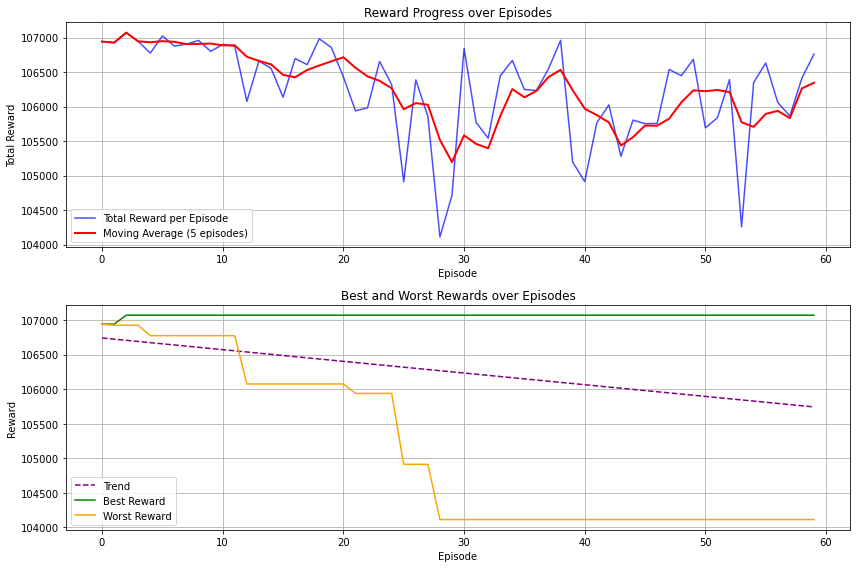

تم حفظ النموذج في: traffic_rl_model.npy


In [ ]:
import traci
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    traci.close()
except Exception:
    pass

ALPHA = 0.7                
GAMMA = 0.9              
EPSILON_START = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.95     
EPISODES = 60

GREEN_PHASES = [0, 2, 4, 6]
YELLOW_DURATION = 2       
MIN_GREEN_DURATION = 5    
MAX_GREEN_DURATION = 20   

MAX_QUEUE = 10          
QUEUE_BINS = 3           
SPEED_BINS = 2            

WAITING_PENALTY = 0.001    
STOP_PENALTY = 0.005       
THROUGHPUT_REWARD = 5.0   
TIME_REWARD = 0.5         
SPEED_REWARD = 1.0        

class QLearningAgent:
    def __init__(self):
        
        self.q_table = {}
        self.epsilon = EPSILON_START
        self.current_phase = 0
        self.phase_duration = 0
        self.yellow_time = 0
        self.last_action_time = 0       
        self.last_state = None          
        self.consecutive_rewards = []    
        self.processed_vehicles = set()
        
        self.state_cache = {}
        self.last_step = 0
        self.cache_valid_steps = 2 

    def get_state(self):
        current_step = traci.simulation.getTime()
        
        if current_step - self.last_step <= self.cache_valid_steps and self.state_cache:
            return self.state_cache
            
        state_features = []
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            queue_length = traci.edge.getLastStepHaltingNumber(approach)
            queue_state = min(queue_length // (MAX_QUEUE // QUEUE_BINS), QUEUE_BINS - 1)
            state_features.append(queue_state)

            if vehicles:
                avg_speed = traci.edge.getLastStepMeanSpeed(approach)
                max_speed = traci.lane.getMaxSpeed(f"{approach}_0")
                speed_ratio = avg_speed / max_speed if max_speed > 0 else 0
                speed_state = min(int(speed_ratio * SPEED_BINS), SPEED_BINS - 1)
            else:
                speed_state = SPEED_BINS - 1
                
            state_features.append(speed_state)
            
           
            approaching_vehicles = len(vehicles)
            state_features.append(min(approaching_vehicles // 3, 2))  
        
        state_features.append(GREEN_PHASES.index(self.current_phase))
        
        state_tuple = tuple(state_features)
        
        self.state_cache = state_tuple
        self.last_step = current_step
        
        return state_tuple

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(GREEN_PHASES)
        else:

            if state not in self.q_table:
                self.q_table[state] = np.zeros(len(GREEN_PHASES))
            return GREEN_PHASES[np.argmax(self.q_table[state])]

    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(GREEN_PHASES))
        
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(len(GREEN_PHASES))
        
        action_idx = GREEN_PHASES.index(action)
        old_value = self.q_table[state][action_idx]
        max_future = np.max(self.q_table[next_state])
        
        state_improvement = 0
        if self.last_state:
            old_queues = sum(self.last_state[i] for i in range(0, len(self.last_state)-1, 3))
            new_queues = sum(next_state[i] for i in range(0, len(next_state)-1, 3))
            if new_queues < old_queues:
                state_improvement = 5.0  
        
        effective_alpha = ALPHA * 1.5
        
        new_value = (1 - effective_alpha) * old_value + effective_alpha * (reward + GAMMA * max_future + state_improvement)
        self.q_table[state][action_idx] = new_value
        self.last_state = next_state

    def get_reward(self):
        
        total_waiting = 0
        total_stopped = 0
        total_throughput = 0
        
        exited_vehicles = set()
        
        for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
            
            vehicles = traci.edge.getLastStepVehicleIDs(approach)
            
            halting_vehicles = traci.edge.getLastStepHaltingNumber(approach)
            total_stopped += halting_vehicles * STOP_PENALTY
            
            waiting_time = sum(min(traci.vehicle.getAccumulatedWaitingTime(veh_id), 100) 
                              for veh_id in vehicles) 
            total_waiting += waiting_time * WAITING_PENALTY
                
            total_throughput += sum(SPEED_REWARD 
                                  for veh_id in vehicles 
                                  if traci.vehicle.getSpeed(veh_id) > 
                                      traci.vehicle.getAllowedSpeed(veh_id) * 0.5)
            
            new_exited = {veh_id for veh_id in vehicles 
                         if traci.vehicle.getLanePosition(veh_id) > 80 
                         and veh_id not in self.processed_vehicles}
            exited_vehicles.update(new_exited)
        
        new_throughput = len(exited_vehicles) * THROUGHPUT_REWARD
        
        self.processed_vehicles.update(exited_vehicles)
        
        base_reward = 50.0
        
        reward = base_reward + ((total_throughput + new_throughput) * 2.0) - ((total_waiting * 0.1) + (total_stopped * 0.2))
        
        current_time = traci.simulation.getTime()
        if current_time - self.last_action_time < 10 and self.last_action_time > 0:
            reward -= 2.0  
        
        episode_time = traci.simulation.getTime() % 3600
        if episode_time > 0:
            time_factor = min(episode_time / 3600, 1.0)
            reward += time_factor * TIME_REWARD * 10  
        self.consecutive_rewards.append(reward)
        if len(self.consecutive_rewards) > 5:
            self.consecutive_rewards.pop(0)
        
        if len(self.consecutive_rewards) >= 3:
            if self.consecutive_rewards[-1] > self.consecutive_rewards[0]:
                reward += 5.0  
        return reward

def run_simulation():
    traci.start(["sumo-gui", "-c", "sumo_config.sumocfg", "--tripinfo-output", "tripinfo.xml", "--no-warnings", "--no-step-log"])
    agent = QLearningAgent()
    rewards_per_episode = []
    moving_avg_rewards = []

    for episode in range(EPISODES):
        
        traci.load(["--start", "-c", "sumo_config.sumocfg", "--no-warnings", "--no-step-log"])
        step = 0
        total_reward = 0
        state = agent.get_state()
        agent.current_phase = 0
        agent.phase_duration = 0
        agent.yellow_time = 0
        action = agent.current_phase
        
        agent.last_action_time = 0
        agent.last_state = None
        agent.consecutive_rewards = []
        agent.processed_vehicles = set()
        agent.state_cache = {}
        agent.last_step = 0.0  
        total_vehicles_processed = 0
        total_wait_time = 0
        
        
        collection_frequency = 5  
        learn_frequency = 3  
        
        while traci.simulation.getMinExpectedNumber() > 0 and step < 3600:
            if agent.yellow_time > 0:
                agent.yellow_time -= 1
                if agent.yellow_time == 0:
                    traci.trafficlight.setPhase("TL", agent.current_phase)
                    traci.trafficlight.setPhaseDuration("TL", agent.phase_duration)
            else:
                agent.phase_duration -= 1
                if agent.phase_duration <= 0:
                    last_action = action
                    action = agent.choose_action(state)
                    
                    if action != agent.current_phase:
                        yellow_phase = agent.current_phase + 1
                        traci.trafficlight.setPhase("TL", yellow_phase)
                        agent.yellow_time = YELLOW_DURATION
                        
                       
                        if action == 0:  
                            demand = traci.edge.getLastStepVehicleNumber("N2TL") + traci.edge.getLastStepVehicleNumber("S2TL")
                        elif action == 2: 
                            demand = traci.edge.getLastStepVehicleNumber("E2TL") + traci.edge.getLastStepVehicleNumber("W2TL")
                        elif action == 4: 
                            
                            demand = traci.edge.getLastStepVehicleNumber("N2TL") + traci.edge.getLastStepVehicleNumber("S2TL")
                            demand = max(1, demand // 2)  
                        elif action == 6: 
                            demand = traci.edge.getLastStepVehicleNumber("E2TL") + traci.edge.getLastStepVehicleNumber("W2TL")
                            demand = max(1, demand // 2)  
                        
                        green_time = MIN_GREEN_DURATION + min(demand, MAX_GREEN_DURATION - MIN_GREEN_DURATION)
                        agent.phase_duration = green_time
                        
                        agent.last_action_time = traci.simulation.getTime()
                    else:
                        
                        agent.phase_duration = MIN_GREEN_DURATION + random.randint(0, 5)
                        
                    agent.current_phase = action

            traci.simulationStep()
            step += 1
            
            if step % collection_frequency == 0:
                current_vehicles_processed = 0
                current_wait_time = 0
                
                for approach in ["N2TL", "E2TL", "S2TL", "W2TL"]:
                    vehicles = traci.edge.getLastStepVehicleIDs(approach)
                    current_wait_time += sum(traci.vehicle.getAccumulatedWaitingTime(veh_id) for veh_id in vehicles)
                    
                    for veh_id in vehicles:
                        if traci.vehicle.getLanePosition(veh_id) > 80 and veh_id not in agent.processed_vehicles:
                            current_vehicles_processed += 1
                            agent.processed_vehicles.add(veh_id)
                
                total_vehicles_processed += current_vehicles_processed
                total_wait_time += current_wait_time

            if step % learn_frequency == 0:
                next_state = agent.get_state()
                reward = agent.get_reward()
                total_reward += reward
                agent.learn(state, action, reward, next_state)
                state = next_state

        if episode < 5:
            agent.epsilon = max(0.7, agent.epsilon * 0.9)    
        elif episode < 10:
            agent.epsilon = max(0.5, agent.epsilon * 0.85)   
        elif episode < 20:
            agent.epsilon = max(0.3, agent.epsilon * 0.8)   
        else:
            agent.epsilon = max(EPSILON_MIN, agent.epsilon * 0.75) 
        rewards_per_episode.append(total_reward)
        
        
        if len(rewards_per_episode) >= 5:
            moving_avg = sum(rewards_per_episode[-5:]) / 5
        else:
            moving_avg = total_reward
        moving_avg_rewards.append(moving_avg)
        
        simulation_minutes = step / 60
        vehicles_per_minute = total_vehicles_processed / max(simulation_minutes, 1)
        avg_wait_time = total_wait_time / max(total_vehicles_processed, 1) if total_vehicles_processed > 0 else 0
        
        print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Avg Reward: {moving_avg:.1f}, "
              f"Epsilon: {agent.epsilon:.3f}, Vehicles/min: {vehicles_per_minute:.1f}, "
              f"Avg Wait: {avg_wait_time:.1f}s")

    traci.close()

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(rewards_per_episode, label="Total Reward per Episode", color='blue', alpha=0.7)
    plt.plot(moving_avg_rewards, label="Moving Average (5 episodes)", color='red', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    
    episodes = np.arange(len(rewards_per_episode))
    z = np.polyfit(episodes, rewards_per_episode, 1)
    p = np.poly1d(z)
    plt.plot(episodes, p(episodes), "--", color='purple', label="Trend")
    
    max_rewards = [max(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    min_rewards = [min(rewards_per_episode[:i+1]) for i in range(len(rewards_per_episode))]
    
    plt.plot(max_rewards, label="Best Reward", color='green')
    plt.plot(min_rewards, label="Worst Reward", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Best and Worst Rewards over Episodes")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("reward_progress.png")  
    plt.show()
    
    
    np.save("traffic_rl_model.npy", dict(agent.q_table))
    print(" traffic_rl_model.npy")

if __name__ == "__main__":
    run_simulation()